# **네이버 영화 리뷰**
**웹크롤링 & 전처리 & 텍스트 분류 모델**

# 웹크롤링

In [ ]:
!pip install bs4

!pip install lxml

In [ ]:
from bs4 import BeautifulSoup
import os
import re
import requests
import sys
import pandas as pd
from pprint import pprint

In [ ]:
# 네이버 영화 리뷰 페이지 주소
url0 = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code='
url1='&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page='

# 영화 코드
movie_num = 93756 #영화 '명량'

# 네이버 영화 리뷰 페이지 주소(전체)
url2= url0 + str(movie_num) + url1

r0 = requests.get(url2)
html0 = r0.text
page0 = BeautifulSoup(html0, 'lxml')

# 전체 리뷰 개수
total_num = page0.select('div[class=score_total] strong[class=total] em')
total_num = total_num[0].text
total_num = total_num.replace(',','')
total_num = int(total_num)

# 전체 리뷰 페이지 개수 (한 페이지에 리뷰 10개)
total_page = total_num // 10 + 1

# 영화 리뷰 데이터셋 생성
movie_review = pd.DataFrame(columns = ['score', 'review'])

# 각 리뷰 페이지에 대해 반복문 실행
for i in range(1, total_page+1):
  url = url2 + str(i)
  r = requests.get(url)
  html = r.text
  page = page = BeautifulSoup(html, 'lxml')

  # 평점 (1~10점)
  score = page.select('div[class=star_score] em')
  score = [i.text for i in score]

  # 감상평
  review = []
  for j in range(len(score)):
    map = 'div[class=score_reple] span[id=_filtered_ment_'+str(j)+']'
    review1 = page.select(map)
    review1 = review1[0].text.strip()
    review.append(review1)

  # 평점과 감상평을 영화 리뷰 데이터셋에 저장
  for j in range(len(score)):
    new_data = {'score': score[j], 'review': review[j]}
    movie_review = movie_review.append(new_data, ignore_index=True)

In [ ]:
movie_review[:10]

,score,review
0,10,오늘 명량 시사회로 방금 보고 왔음. 단연코 올해의 수작임. 밑에 평론가들 캐릭터 ...
1,10,"이순신, 그는 신이다."
2,10,군도보다 훨씬 잼있음..극장가서 꼭 보세요
3,10,29일 시사회로 봤어요냉정하게이건 꼭 봐야해..굿
4,10,오늘 아침에 조조로 보고왔습니다. 8월4일에 해군에 입대하는데. 그전에 보기 잘한 ...
5,10,정말 재미있네요 잘보고 왔습니다 시사회
6,9,"극찬할 수는 없지만 이 정도면 내용, 영상, 연출 전부 꽤나 뛰어난 작품이지 않은가..."
7,10,국가에 버림을 받아도 의리로 지키려는 충신. 피를 흘리면서 싸우는 군인들의 투지. ...
8,10,보는 내내 가슴찡하고 울컥하는 진짜 최고의 영화ㅠㅠ한 순간도 놓칠 수 없는 해전씬이...
9,10,작금의 이시점에 국가가 혼란하고 위태할수록국가를 직간접으로 책임지고 있는 리더에게 ...


In [ ]:
print('총 리뷰의 수 :', len(movie_review))

총 리뷰의 수 : 64564


# 데이터 전처리

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 460kB 44.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

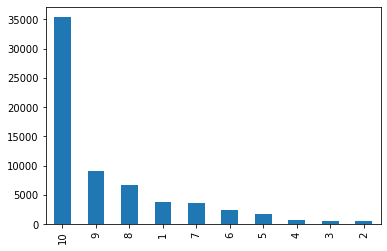

In [ ]:
# 데이터 분포 확인
movie_review['score'].value_counts().plot(kind = 'bar')

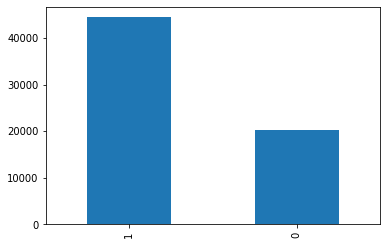

In [ ]:
# 평점이 8 초과인 경우 1, 8 이하인 경우 0으로 labeling
movie_review['score'] = movie_review['score'].astype('int')
movie_review['label'] = np.select([movie_review.score > 8], [1], default=0)
movie_review['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 각 열에 대해서 중복을 제외한 샘플의 수 카운트
movie_review['score'].nunique(), movie_review['review'].nunique(), movie_review['label'].nunique()

(10, 64104, 2)

In [ ]:
# review 열 중복 제거
movie_review.drop_duplicates(subset=['review'], inplace=True)
print('총 샘플의 수 :', len(movie_review))

총 샘플의 수 : 64104


In [ ]:
# NA값 있는지 확인
print(movie_review.isnull().values.any())

False


In [ ]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(movie_review, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 48078
테스트용 리뷰의 개수 : 16026


In [ ]:
# 훈련 데이터 한글과 공백을 제외하고 모두 제거
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

score      0
review    51
label      0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# 테스트 데이터에 대해서도 똑같이 처리
test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 16003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

# 텍스트 분류 모델

**토큰화**

In [ ]:
# 형태소 분석기
okt = Okt()

In [ ]:
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
X_train = []
for sentence in train_data['review']:
    temp_X = []
    temp_X = okt.morphs(str(sentence), stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['한국인', '라면', '모두', '보다'], ['괴물', '번방', '대장', '먹다'], ['기', '대안', '햇', '늘다', '기', '대안', '햇', '다']]


In [ ]:
X_test = []
for sentence in test_data['review']:
    temp_X = []
    temp_X = okt.morphs(str(sentence), stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

**정수 인코딩**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '이다': 4, '이순신': 5, '있다': 6, '감동': 7, '정말': 8, '좋다': 9, '너무': 10, '최고': 11, '없다': 12, '적': 13, '재밌다': 14, '최민식': 15, '만': 16, '같다': 17, '다': 18, '연기': 19, '되다': 20, '진짜': 21, '님': 22, '않다': 23, '이순신장군': 24, '아니다': 25, '생각': 26, '꼭': 27, '재미있다': 28, '로': 29, '역사': 30, '장군': 31, '그': 32, '요': 33, '말': 34, '것': 35, '명량': 36, '에서': 37, '자다': 38, '배우': 39, '점': 40, '지루하다': 41, '인': 42, '더': 43, '보고': 44, '볼': 45, '다시': 46, '만들다': 47, '재미': 48, '사람': 49, '그냥': 50, '가다': 51, '나오다': 52, '한번': 53, '시간': 54, '고': 55, '느끼다': 56, '게': 57, '평점': 58, '우리': 59, '가슴': 60, '많다': 61, '기대': 62, '들다': 63, '하고': 64, '수': 65, '스토리': 66, '장면': 67, '모르다': 68, '오다': 69, '안': 70, '아쉽다': 71, '정도': 72, '야하다': 73, '전': 74, '나': 75, '중': 76, '못': 77, '짱': 78, '알다': 79, '까지': 80, '내': 81, '그렇다': 82, '많이': 83, '대박': 84, '싶다': 85, '네': 86, '역시': 87, '감사하다': 88, '주다': 89, '내용': 90, '우리나라': 91, '완전': 92, '처음': 93, '애국심': 94, '때': 95, '소름': 96, '두': 97, 'ㅠㅠ': 98, '멋지다': 99, '느낌': 100, '조금': 101,

In [ ]:
# 빈도수 낮은 단어들은 배제
# 빈도수 3회 미만인 단어들의 비중 확인해보기

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17432
등장 빈도가 2번 이하인 희귀 단어의 수: 10220
단어 집합에서 희귀 단어의 비율: 58.62781092244149
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.037816639059298


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7214


In [ ]:
# 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[217, 139, 212, 3], [2295, 2568, 2061, 175], [125, 687, 460, 320, 125, 687, 460, 19]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

**빈 샘플 제거**

In [ ]:
# 빈도수가 낮아서 삭제한 단어 샘플
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

48025
48025


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


**패딩**

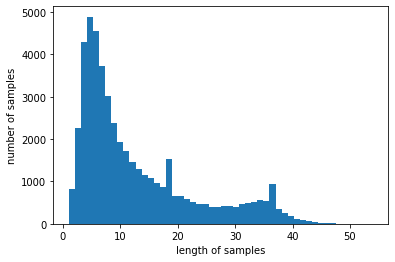

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 95.61061946902655


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

**LSTM으로 네이버 영화 리뷰 감성 분류하기**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
641/641 [==============================] - 20s 18ms/step - loss: 0.4836 - acc: 0.7734 - val_loss: 0.4066 - val_acc: 0.8271

Epoch 00001: val_acc improved from -inf to 0.82707, saving model to best_model.h5
Epoch 2/15
641/641 [==============================] - 11s 17ms/step - loss: 0.3699 - acc: 0.8434 - val_loss: 0.3906 - val_acc: 0.8306

Epoch 00002: val_acc improved from 0.82707 to 0.83061, saving model to best_model.h5
Epoch 3/15
641/641 [==============================] - 11s 17ms/step - loss: 0.3488 - acc: 0.8538 - val_loss: 0.3919 - val_acc: 0.8312

Epoch 00003: val_acc improved from 0.83061 to 0.83123, saving model to best_model.h5
Epoch 4/15
641/641 [==============================] - 11s 17ms/step - loss: 0.3391 - acc: 0.8585 - val_loss: 0.3813 - val_acc: 0.8345

Epoch 00004: val_acc improved from 0.83123 to 0.83446, saving model to best_model.h5
Epoch 5/15
641/641 [==============================] - 11s 17ms/step - loss: 0.3304 - acc: 0.8639 - val_loss: 0.4164 - val_a

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

501/501 [==============================] - 3s 5ms/step - loss: 0.3946 - acc: 0.8405

 테스트 정확도: 0.8405


**리뷰 예측해보기**

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

92.36% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

99.78% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

99.64% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

99.20% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('또 보러 가고 싶다')

96.57% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('처음부터 끝까지 졸다 왔어요')

86.25% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('솔직히 말해서 돈 아까웠음')

86.45% 확률로 부정 리뷰입니다.

